# Data Analysis for OH<sup>-</sup>(H<sub>2</sub>O)<sub>5</sub> DMC Data

### Install necessary libraries and define constants

In [9]:
import numpy as np
import pyvibdmc as pv
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.spatial.distance import pdist, squareform
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from nn_dmc import *

import h5py

au_to_cm = 219474.63136320

au_to_ang = 0.529177249

h11o6_atoms = np.array([8,1,1,8,1,1,8,1,1,8,1,1,8,1,1,8,1])
h11o6_groups = [[0,1,2],[3,4,5],[6,7,8],[9,10,11],[12,13,14],[15,16]]

h11o6_atom_names = ['O','H','H','O','H','H','O','H','H','O','H','H','O','H','H','O','H']

path = f'C:/Users/gjaco/OneDrive/Documents/UW/McCoy Group/Machine Learning/'

### Optimized MOB-ML energies and structures for the key isomers of this complex

In [26]:
h11o6_4_1_mobml_energy = -457.86049912
energy_shift = h11o6_4_1_mobml_energy*au_to_cm

h11o6_4_1_mobml_min = np.array([-5.22071019,  0.45219087,  0.39258194, -3.79359053, 0.77731208, -0.76506451,
 -4.63783003,  1.15008802,  1.95744275,  0.13045852,  2.97610771,  2.14963861,
 -0.24565512,  2.53532275,  0.35690278,  1.45844052,  4.19441247,  2.04181715,
  4.55204562,  0.84064589, -1.95147809,  4.5837319,  -0.20433122, -0.46486598,
  2.74592397,  0.97510823, -2.30298491, -1.01837134, -3.71483304, -0.9594928,
 -2.69401462, -3.61965215, -0.27325381, -0.84004062, -2.04695746, -1.78547328,
  2.60212736, -1.9994216,   2.84261588,  1.53524363, -2.95696682,  1.70521186,
  1.7416188,  -0.38849436,  2.93411234, -0.85953764,  1.1431051,  -2.37646317,
 -1.15889846,  1.91653967, -3.98520012]).reshape(17,3)

h11o6_4_1_zpe = 29167

In [20]:
h11o6_c5_mobml_min = np.array([-4.99976143,  1.057245  ,  0.59371411, -3.58031265,  1.36848287,
       -0.60601623, -4.4786128 ,  1.76362457,  2.1785895 ,  0.11122927,
        3.93080013,  1.53538347, -0.25857121,  3.48571297, -0.24150698,
        1.64959851,  4.65021882,  2.19247899,  4.07940818,  1.83390348,
       -1.31349184,  4.49822815, -0.08698409, -1.10545191,  2.27156402,
        1.94261942, -1.70192502, -2.21347384, -3.14491978, -1.57009773,
       -3.89474416, -3.21024761, -0.93548995, -2.05006924, -1.48220658,
       -2.42431057,  2.32725425, -2.70493488, -3.38793855,  1.36315384,
       -4.22935794, -3.48285948,  1.2420602 , -1.28711127, -2.75801729,
       -0.85939069,  1.14993606, -2.38466412, -1.1462322 ,  1.93551405,
       -3.99824445]).reshape(17,3)

h11o6_c5_mobml_energy = -457.85571091

h11o6_c5_zpe = 29940

In [21]:
h11o6_c4_1_planar_mobml_min = np.array([-4.99431104,  2.85356531,  1.49841384, -3.78806373,  2.30121231,  0.1999704,
 -4.13566831,  4.31098639,  2.14685086, -0.25095006,  6.40975405,  0.3538017,
 -0.494261,    4.76417524, -0.49091439,  1.53820153,  6.52965118,  0.53783766,
  3.84723927,  2.25039946, -1.43581273,  4.43653887,  0.75193413, -0.60775798,
  1.99715772,  2.00476222, -1.61003495, -1.13982384, -2.96231938, -1.02941067,
 -2.84682627, -3.49511431, -0.7852611,  -1.22542991, -1.0830078,  -1.35947127,
  3.21907884, -4.20000279, -3.62898326,  1.62257543, -4.02975695, -2.72935147,
  3.48620193, -2.54197808, -4.30008117, -1.17129061,  1.82108788, -1.85099183,
 -1.68117426,  2.10723635, -3.56327478]).reshape(17,3)

h11o6_c4_1_planar_mobml_energy = -457.854961538757

h11o6_c4_1_planar_zpe = 29151

In [6]:
h11o6_c4_1_rotated_mobml_min = np.array([-5.04845812,  2.42349782, -0.77422458, -3.54291551,  2.50022545, -1.86801676,
 -4.37800533,  2.76867824,  0.86402186,  1.23508108,  3.60351132,  1.21491547,
  0.64696376,  3.50468305, -0.53873352,  0.70928194,  2.01423378,  1.8927728,
  3.38817222, -0.19781375, -4.0778668,   4.26918993,  0.20064136, -2.55641497,
  1.86259844,  0.93383725, -4.00549482, -3.38425664, -1.38752027, -5.54256069,
 -4.76668475, -1.35023804, -4.37166935, -2.287793,   -0.02618462, -4.91207414,
  0.72376298, -4.42918611, -2.45421359, -0.52357327, -4.06428319, -3.71392061,
  1.88443628, -3.0457136,  -2.74511358, -0.66516562,  2.5537486,  -3.54154483,
 -0.77252473,  3.7983702,  -4.84358342]).reshape(17,3)



In [22]:
h11o6_3_2_mobml_min = np.array([-5.22834269,  0.44571077,  0.38850877, -3.79846262,  0.75305581,
       -0.80831139, -4.66367366,  0.02405621,  1.91659789,  1.3068778 ,
        3.42968259,  2.04120642,  0.92702398,  2.98977328,  0.25059656,
        2.61320758,  4.6820796 ,  2.02106194, -1.44356168, -0.56816502,
        4.1468525 , -2.22331932, -1.50380615,  5.49473736,  0.13961296,
       -0.73200426,  3.75503672,  0.56744692, -3.45124437, -1.34285818,
       -1.12468932, -3.39523289, -0.70348829,  0.73287353, -1.78639577,
       -2.19257348,  3.59854851, -1.50667853,  1.99405776,  2.54988287,
       -2.51348674,  0.85750096,  2.72560849,  0.09291783,  2.17225892,
       -0.85786001,  1.1468747 , -2.38368146, -1.13470487,  1.93630773,
       -4.0062002 ]).reshape(17,3)

h11o6_3_2_mobml_energy = -457.8520851570613

h11o6_3_2_zpe = 28990

In [23]:
h11o6_3_2_up_down_mobml_min = np.array([[-5.19012673,  2.48490874,  0.50049639],
       [-4.16140358,  1.98024484, -0.94523101],
       [-4.45108731,  1.57917835,  1.8824176 ],
       [ 0.4541031 ,  1.00087936,  2.58037763],
       [ 0.02805151,  2.26507734,  1.34829982],
       [ 0.13499535, -0.57512938,  1.659691  ],
       [ 3.29150457,  2.34962092, -3.21073588],
       [ 3.64891112,  1.70686639, -1.54980549],
       [ 1.47643108,  1.99827471, -3.39986166],
       [-0.11060966, -2.69757701, -0.84596281],
       [-1.54241179, -3.81113789, -0.87347237],
       [-0.82580123, -0.97768312, -1.91210566],
       [ 3.15469913, -2.88953634, -5.10168342],
       [ 2.09084789, -3.07753297, -3.62635267],
       [ 3.48686847, -1.10703686, -5.09747675],
       [-1.69900569,  0.91067681, -3.17923094],
       [-2.18977871, -0.01829788, -4.6611643 ]])

h11o6_3_2_up_down_mobml_energy = -457.8510452237062

h11o6_3_2_up_down_zpe = 27868

In [24]:
h11o6_3_2_book_mobml_min = np.array([[-4.55830735, -0.30297528,  2.39294133],
       [-3.4110611 , -0.43614059,  0.82905158],
       [-6.03240291, -1.2998169 ,  2.09842537],
       [ 2.16414596,  2.40056691,  1.44199665],
       [ 0.82869741,  1.50611536,  0.48855338],
       [ 1.50573877,  2.50986028,  3.14001099],
       [-1.2676794 ,  1.87326783,  5.85987668],
       [-2.51859038,  1.26397435,  4.64806066],
       [-0.50547684,  0.36495257,  6.496762  ],
       [ 1.60242039, -4.15770277, -2.03695978],
       [ 0.88426855, -5.63792472, -1.28171093],
       [ 0.33584945, -2.75104714, -1.70293483],
       [ 5.9212046 , -1.49297801,  0.11248176],
       [ 4.65726321, -2.5995253 , -0.59982284],
       [ 4.99584005,  0.06382539,  0.4069089 ],
       [-1.33965098, -0.40487889, -1.13577576],
       [-1.8893165 ,  0.2100114 , -2.73679273]])

h11o6_3_2_book_mobml_energy = -457.85459788929717

h11o6_3_2_book_zpe = 28285

### Relative Energy Analysis of the various isomers

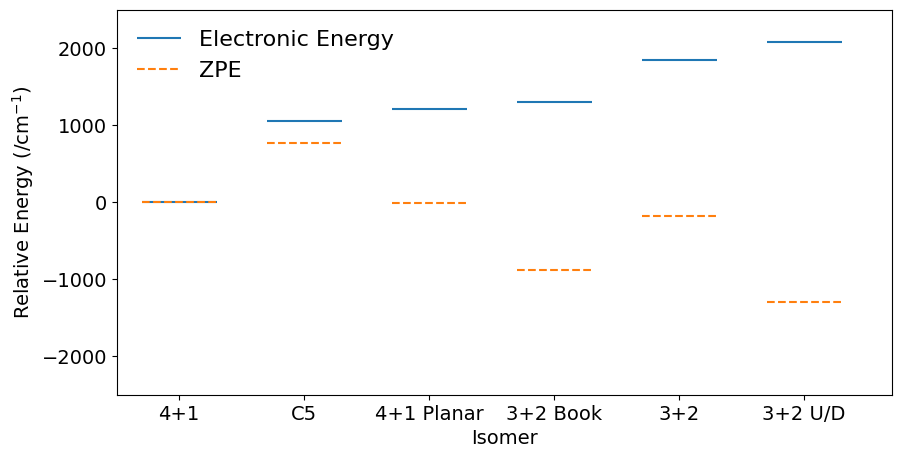

In [46]:
plt.rcParams["figure.figsize"] = [10, 5]

energy_list = [h11o6_c5_mobml_energy, h11o6_c4_1_planar_mobml_energy, h11o6_3_2_book_mobml_energy, h11o6_3_2_mobml_energy, h11o6_3_2_up_down_mobml_energy]
zpe_list = [h11o6_c5_zpe, h11o6_c4_1_planar_zpe, h11o6_3_2_book_zpe, h11o6_3_2_zpe, h11o6_3_2_up_down_zpe]

for i, energy in enumerate(energy_list):
    plt.hlines((energy-h11o6_4_1_mobml_energy)*au_to_cm, 5*(i+1), 5*(i+1)+3)
plt.hlines(0, 0, 3, label='Electronic Energy')

for i, zpe in enumerate(zpe_list):
    plt.hlines((zpe-h11o6_4_1_zpe), 5*(i+1), 5*(i+1)+3, color='tab:orange', linestyle='dashed')
plt.hlines(0, 0, 3, label='ZPE', color='tab:orange', linestyle='dashed')

plt.legend(fontsize=16, frameon=False, loc='upper left')
plt.xlabel('Isomer')
plt.xlim(-1,30)
plt.xticks(np.arange(1.5,26.5+5,5), ['4+1', 'C5', '4+1 Planar', '3+2 Book', '3+2', '3+2 U/D'])
plt.ylabel(r'Relative Energy (/cm$^{-1}$)')
plt.ylim(-2500,2500)
plt.show()

### Load in training data generated from MOB-ML DMC simulations

In [136]:
#Dictionaries for the starting timesteps of the various simulation types for each of the starting isomers
#MOB-ML has holes and has to be restarted every time it fails to converge

train_4_1_dict = {'min_starts': [[0], [0, 34]], 'reg_starts': [[0], [0], [0], [0, 528], [0]], 'wide_starts': [[0, 279, 906, 915], [0, 298, 451, 939]], 'test_starts': [[0, 988]]}
train_c5_dict = {'min_starts': [[0, 45, 374, 698, 812], [0, 944]], 'reg_starts': [[0], [0, 128, 411], [0], [0], [0]], 'wide_starts': [[0, 88, 647], [0, 198, 875]], 'test_starts': [[0, 603, 941]]}
train_3_2_dict = {'min_starts': [[0, 82], [0, 68]], 'reg_starts': [[0, 815], [0], [0, 978], [0, 728, 921], [0]], 'wide_starts': [[0, 249, 313, 877], [0, 683]], 'test_starts': [[0, 473]]}

In [153]:
isomer = 'c5'
sim_type = 'reg'
sim_num = 2

if isomer == '3_2':
    train_dict = train_3_2_dict
elif isomer == '4_1':
    train_dict = train_4_1_dict
elif isomer == 'c5':
    train_dict = train_c5_dict
else:
    print("Not a valid isomer name")


train_energies_list = []
train_cds_list = []

if sim_type == 'min':
    sim = '500w_1000ts_1dt'
    starts = train_dict['min_starts'][sim_num - 1]
    end = 1000
elif sim_type == 'wide':
    sim = '1000w_1000ts_10dt'
    starts = train_dict['wide_starts'][sim_num - 1]
    end = 1000
elif sim_type == 'reg':
    if sim_num in [1, 2]:
        sim = '200w_5000ts_10dt'
        end = 1000
    else:
        sim = '200w_1000ts_10dt'
        end = 1000

    starts = train_dict['reg_starts'][sim_num - 1]

elif sim_type == 'test':
    sim = '1000w_1000ts_10dt_min'
    starts = train_dict['test_starts'][sim_num - 1]
    end = 1000

else:
    print("Not a valid sim type")

print(f'starting {isomer} {sim_type} sim number {sim_num}')

for j in range(len(starts)):
    print(f'starting at timestep {starts[j]}')

    path = f'C:/Users/gjaco/OneDrive/Documents/UW/McCoy Group/H11O6-/Data/mobml_pyscf/{isomer}_min/sim_{sim_num}/{sim}_{starts[j]}_start'

    training_sim = pv.SimInfo(f'{path}/h11o6_0_sim_info.hdf5')
    
    if j+1 < len(starts):
        for b in range(starts[j+1]-starts[j]):
            cds,energies = training_sim.get_training(f'{path}/h11o6_0_training_{b}ts.hdf5',ret_ang=False, ret_cm=True)
            
            train_cds_list.append(cds)
            train_energies_list.append(energies-energy_shift) #record energy relative to 4+1 minimum
            
            #print(f'snapshot {b+starts[j]} done')
    else:
        for b in range(end-starts[j]):
            cds,energies = training_sim.get_training(f'{path}/h11o6_0_training_{b}ts.hdf5',ret_ang=False, ret_cm=True)
            
            train_cds_list.append(cds)
            train_energies_list.append(energies-energy_shift)
            
            #print(f'snapshot {b+starts[j]} done')
     


starting c5 reg sim number 2
starting at timestep 0
starting at timestep 128
starting at timestep 411


In [154]:
train_energies = np.concatenate(train_energies_list)
train_cds = np.concatenate(train_cds_list)

In [155]:
#check energy range of simulation
print(np.min(train_energies), np.max(train_energies))

2029.4096198827028 94490.35169012845


In [156]:
np.save(f'C:/Users/gjaco/OneDrive/Documents/UW/McCoy Group/Machine Learning/h11o6/training_data/h11o6_{isomer}_mobml_{sim_type}_sim_{sim_num}_training_cds.npy',train_cds)
np.save(f'C:/Users/gjaco/OneDrive/Documents/UW/McCoy Group/Machine Learning/h11o6/training_data/h11o6_{isomer}_mobml_{sim_type}_sim_{sim_num}_training_energies.npy',train_energies)

### Create full training data sets

In [6]:
def make_training_set(isomers, sim_types, sim_nums):
    """
    Function that takes in specified MOB-ML simulations for the isomers of OH-W5
    to form a training data set for NN training

    example input:
    isomers = ['c5']
    sim_types = ['min', 'wide', 'reg']
    sim_nums = [[1], [1], [1,2,3,4,5]]

    Returns coordinates array and energies array 
    """
    path = f'C:/Users/gjaco/OneDrive/Documents/UW/McCoy Group/Machine Learning/h11o6/training_data'

    total_cds = []
    total_energies = []

    for isom in isomers:
        for i, sim in enumerate(sim_types):
            for num in sim_nums[i]:
                cds = np.load(f'{path}/h11o6_{isom}_mobml_{sim}_sim_{num}_training_cds.npy')
                energies = np.load(f'{path}/h11o6_{isom}_mobml_{sim}_sim_{num}_training_energies.npy')

                total_cds.append(cds)
                total_energies.append(energies)

    total_cds = np.concatenate(total_cds)
    total_energies = np.concatenate(total_energies)

    return total_cds, total_energies

In [ ]:
# Load in DMC snapshot data, skipping over timesteps that failed

h11o6_snapshot_cds = np.load(f'{path}/h11o6/training_sets/h11o6_3_2_unguided_100k_75kts_snapshot.npy')
h11o6_dmc_cds = []
h11o6_dmc_energies = []
for i in np.arange(0, len(h11o6_snapshot_cds), 1000):
    try:
        energy = np.load(f'{path}/h11o6/training_sets/h11o6_snapshots/{i}-{i+1000}_3_2_energies.npy')
        h11o6_dmc_energies.append(energy)
        h11o6_dmc_cds.append(h11o6_snapshot_cds[i:i+1000])
    except:
        print(f'Skipping {i}-{i+1000}')
        continue
h11o6_dmc_energies = np.concatenate(h11o6_dmc_energies)*au_to_cm - energy_shift
h11o6_dmc_cds = np.concatenate(h11o6_dmc_cds)

np.save(f'{path}/h11o6/training_data/h11o6_3_2_dmc_energies.npy', h11o6_dmc_energies)
np.save(f'{path}/h11o6/training_data/h11o6_3_2_dmc_cds.npy', h11o6_dmc_cds)

### Compare energy distributions between the different parts of the training data

In [218]:
def plot_training_data(isomer):

    _, train_min_energies = make_training_set([isomer], ['min'], [[1]])
    _, train_wide_energies = make_training_set([isomer], ['wide'], [[1]])
    _, train_reg_energies = make_training_set([isomer], ['reg'], [[1,2,3,4,5]])
    _, train_test_energies = make_training_set([isomer], ['test'], [[1]])

    dmc_energies = np.load(f'{path}/h11o6/training_data/h11o6_{isomer}_dmc_energies.npy')

    n, bins = np.histogram(train_min_energies, bins=np.arange(0, 100000, 200), density = True)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    plt.plot(bin_centers, n, label = f'{isomer} min')

    n, bins = np.histogram(train_wide_energies, bins=np.arange(0, 100000, 200), density = True)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    plt.plot(bin_centers, n, label = f'{isomer} wide')

    n, bins = np.histogram(train_reg_energies, bins=np.arange(0, 100000, 200), density = True)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    plt.plot(bin_centers, n, label = f'{isomer} reg')

    n, bins = np.histogram(train_test_energies, bins=np.arange(0, 100000, 200), density = True)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    plt.plot(bin_centers, n, label = f'{isomer} test')

    n, bins = np.histogram(dmc_energies, bins=np.arange(0, 100000, 200), density = True)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    plt.plot(bin_centers, n, label = f'{isomer} DMC')

    plt.xlabel(r'MOB-ML Energy (/cm$^{-1}$)')
    plt.ylabel('Density of Points')
    plt.xlim(0, 80000)
    plt.ylim(0, 6e-5)
    plt.legend()
    plt.show()

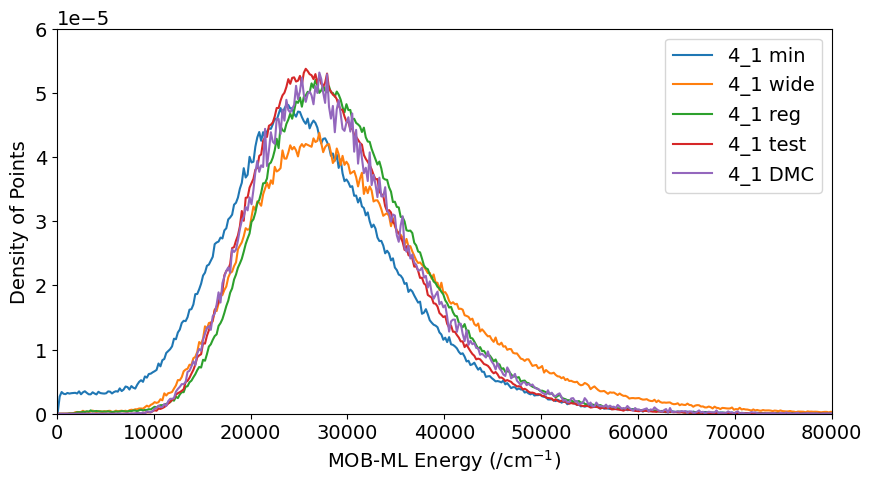

In [219]:
plot_training_data('4_1')

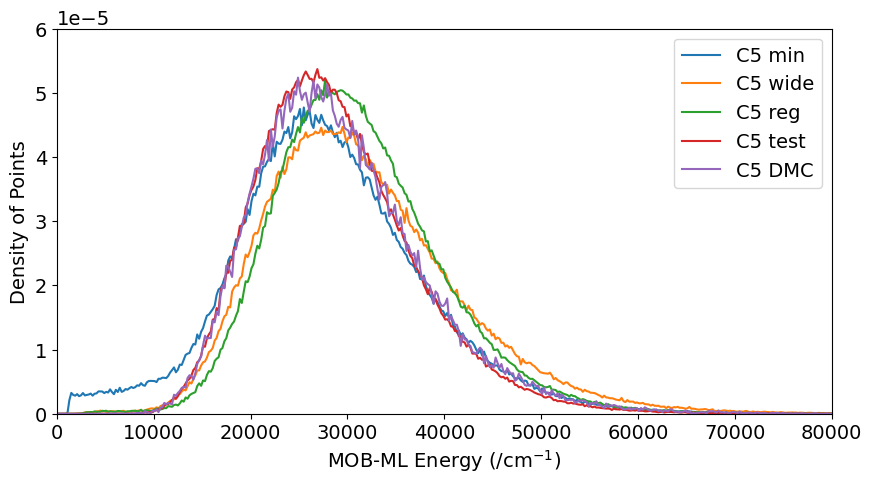

In [220]:
plot_training_data('C5')

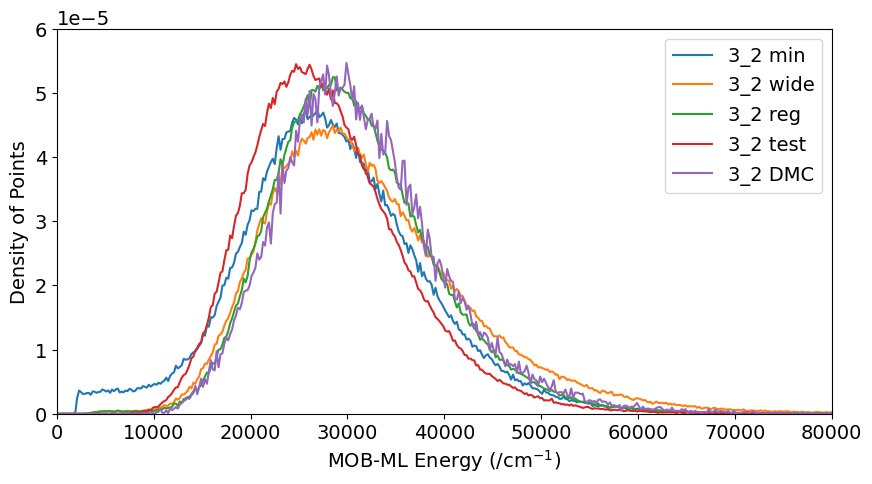

In [221]:
plot_training_data('3_2')

### PCA Analysis of Training Features

In [13]:
# Load in 
sim_type = 'reg'
reg_cds, reg_energies = make_training_set(['c5','4_1','3_2'], [sim_type], [[1,2,3,4,5]])

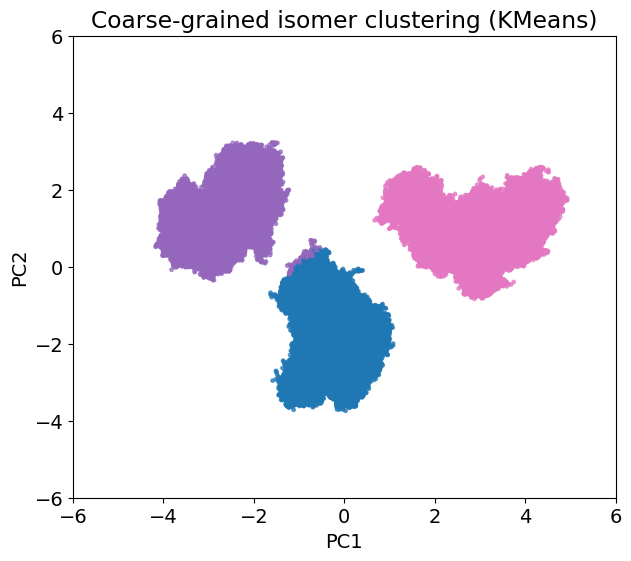

In [10]:
# --------------------------------------------------------
# 1. Load coordinates & extract Oxygens
# --------------------------------------------------------

coords = reg_cds

oxygen_idx = [0, 3, 6, 9, 12, 15]
oxygen_coords = coords[:, oxygen_idx, :]  # shape: (N,6,3)
N, nO, _ = oxygen_coords.shape

# --------------------------------------------------------
# 2. Compute pairwise O–O distance vectors
# --------------------------------------------------------
dist_vectors = np.array([pdist(oxygen_coords[i]) for i in range(N)])
# Standardize
dist_vectors = (dist_vectors - dist_vectors.mean(axis=0)) / dist_vectors.std(axis=0)

# --------------------------------------------------------
# 3. Optional: reduce dimensionality for visualization
# --------------------------------------------------------
pca = PCA(n_components=5)
X_pca = pca.fit_transform(dist_vectors)

# --------------------------------------------------------
# 4. Cluster into a small number of isomers
# --------------------------------------------------------
n_isomers = 3  # coarse-grain into 4 main clusters
kmeans = KMeans(n_clusters=n_isomers, n_init=50, random_state=0)
labels = kmeans.fit_predict(X_pca)

# --------------------------------------------------------
# 5. Plot PC1 vs PC2
# --------------------------------------------------------
plt.figure(figsize=(7,6))
plt.xlim(-6, 6)
plt.ylim(-6, 6)

# Define the colors you want for each cluster
cluster_colors = {
    0: "tab:blue",
    1: "tab:purple",
    2: "tab:pink",
    #3: "tab:red"
}

# Map labels to colors
colors = [cluster_colors[lbl] if lbl in cluster_colors else "gray" for lbl in labels]

plt.scatter(X_pca[:,0], X_pca[:,1], c=colors, s=6, alpha=0.7)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Coarse-grained isomer clustering (KMeans)")
plt.show()

# --------------------------------------------------------
# 6. Identify representative / centroid geometries per cluster
# --------------------------------------------------------
# coords: full 17-atom geometries
# labels: cluster assignments from KMeans
n_clusters = len(np.unique(labels))
centroid_geometries_full = []

for lbl in range(n_clusters):
    cluster_idx = np.where(labels == lbl)[0]  # indices of structures in this cluster
    cluster_coords = coords[cluster_idx]      # shape: (n_cluster, 17, 3)
    centroid = cluster_coords.mean(axis=0)    # shape: (17, 3)
    centroid_geometries_full.append(centroid)

# Convert to array
centroid_geometries_full = np.array(centroid_geometries_full)  # shape: (n_clusters, 17, 3)

In [14]:
for i, geom in enumerate(centroid_geometries_full):
    save_xyz_file(f'{path}/h11o6/geometries/h11o6_{sim_type}_pca_{n_isomers}_isomer_{i+1}.xyz', h11o6_atom_names, centroid_geometries_full[0]*au_to_ang)

### NN Model Error Analysis

### DMC Simulation Analysis

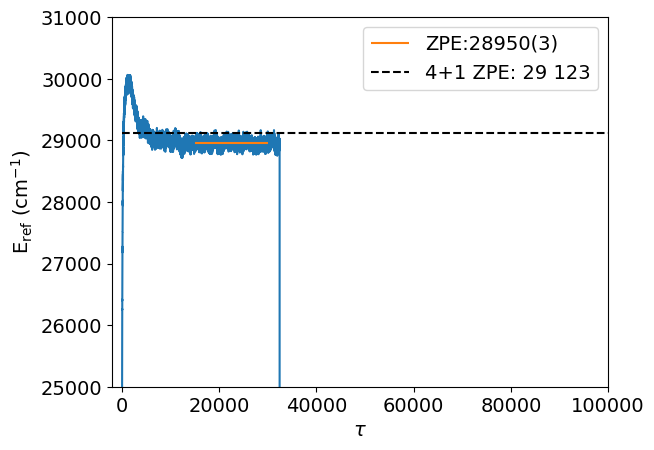

28950.229918207082 0.0


In [75]:
import numpy as np
import pyvibdmc as pv
ZPEs = []
ZPEs_2 = []
walkers = 100000
timesteps = 100000
tau = np.linspace(0,timesteps,timesteps)
for i in range(1):
    #tutorial_sim = pv.SimInfo('C:/Users/gjaco/OneDrive/Documents/UW/McCoy Group/H11O6-/Data/NN_Data/3_2_start/450_3hidden_6_decay_0_dropout_2mill_revised_molec_atom_sort_standardized/model_5_reg/dist_65_energy_1/h2o_guided/1.0w_100000_walkers_50000t_1dt/H11O6_{2}_sim_info.hdf5'.format(walkers,timesteps,i))
    tutorial_sim = pv.SimInfo('C:/Users/gjaco/OneDrive/Documents/UW/McCoy Group/H11O6-/Data/EGNN_Data/3_2_up_down_start/64_3layers_3freqs_6decay_1gradclip_2mill_std_energies/gpu/h2o_guided/1.0w_100000_walkers_100000t_1dt/H11O6_{2}_sim_info.hdf5'.format(walkers,timesteps,i))
    #ZPE = tutorial_sim.get_zpe(onwards=20000, ret_cm=True)
    #ZPEs.append(ZPE)

    vref = tutorial_sim.get_vref(ret_cm=True)

    means = []
    for j in range(15000,30000,5000):
        mean = np.mean(vref[j:j+5000,1])
        means.append(mean)

    std = np.std(means)
    
    plt.plot(tau,vref[:,1],
             #label=f'ZPE: {ZPE:.0f}({std:.0f})'
             )
    
    ZPE = np.mean(vref[15000:30000,1])
    ZPEs.append(ZPE)
    #plt.hlines(ZPE_1,20000,50000,color='black',label=f'ZPE: {ZPE_1:.0f}({std:.0f})')

    """tutorial_sim = pv.SimInfo('C:/Users/gjaco/OneDrive/Documents/UW/McCoy Group/H11O6-/Data/NN_Data/c5_start/450_3hidden_6_decay_0_dropout_2mill_revised_molec_atom_sort_standardized/model_5_reg/dist_65_energy_1/unguided/1.0w_100000_walkers_50000t_1dt/H11O6_{2}_sim_info.hdf5'.format(walkers,timesteps,i))
    ZPE = tutorial_sim.get_zpe(onwards=35000, ret_cm=True)
    ZPEs.append(ZPE)

    tau = np.linspace(0,50000,50000)

    means = []
    for j in range(35000,50000,5000):
        mean = np.mean(vref[j:j+5000,1])
        means.append(mean)

    std = np.std(means)

    vref = tutorial_sim.get_vref(ret_cm=True)"""
    
    #plt.plot(tau,vref[:,1],
    #         label=f'ZPE: {ZPE:.0f}({std:.0f})'
    #         )
    
    plt.hlines(ZPE,15000,30000,color='tab:orange',label=f'ZPE:{ZPE:.0f}({std:.0f})')
    plt.hlines(29123, 0,100000,color='black',linestyle='dashed',label='4+1 ZPE: 29 123')

    plt.ylabel(r'E$_\mathrm{ref}$ (cm$^{-1}$)')
    plt.xlabel(r'$\tau$')
    #plt.xticks(np.arange(0,200000,50000))
    plt.xlim(-2000,100000)
    plt.ylim(25000,31000)
    plt.legend()
    plt.show()

print(np.mean(ZPEs), np.std(ZPEs))


In [10]:
np.std([28940,28946])

np.float64(3.0)

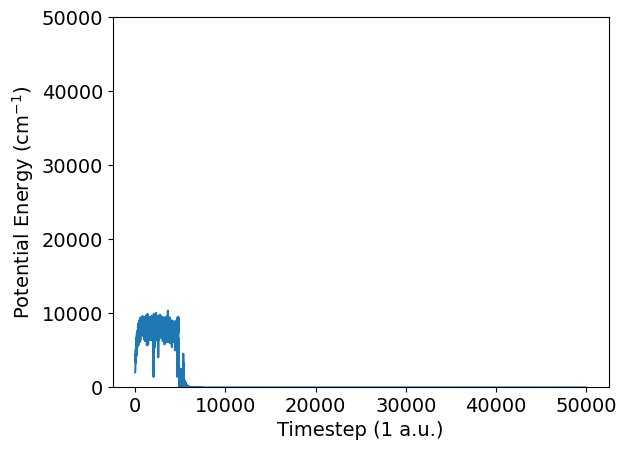

In [12]:
highest, lowest, average, num_walkers, local = parse_log_file('C:/Users/gjaco/OneDrive/Documents/UW/McCoy Group/H11O6-/Data/NN_Data/3_2_start/450_3hidden_6_decay_0_dropout_2mill_revised_molec_atom_sort_standardized/model_5_reg/dist_65_energy_1/unguided/1.0w_100000_walkers_50000t_1dt/H11O6_1_log.txt')

vref = []
for i in range(len(average)):
    v = average[i] - (0.5)*(num_walkers[i] - 100000)/100000
    vref.append(v)
#plt.plot(np.arange(0,len(vref),1),vref)
plt.plot(np.arange(0,len(lowest),1),lowest)
#plt.hlines(1000, 0, 50000, color='black', linestyle='dashed')
plt.ylim(0,50000)
#plt.xlim(-2000,52000)
plt.xlabel('Timestep (1 a.u.)')
plt.ylabel('Potential Energy (cm$^{-1}$)')
plt.show()

In [7]:
test_x = np.load('./h11o6/training_sets/h11o6_mobml_10_test_no_sort_revised_X_c5.npy')
train_x = np.load('./h11o6/training_sets/h11o6_mobml_full_training_no_sort_revised_X_c5.npy')

means = np.mean(train_x,axis=0)
stds = np.std(train_x,axis=0)

with np.errstate(divide='ignore', invalid='ignore'):
    standard_X_test = (test_x - means)/stds

In [8]:
np.save('./h11o6/training_sets/h11o6_mobml_10_test_no_sort_revised_X_c5_standardized.npy',standard_X_test)

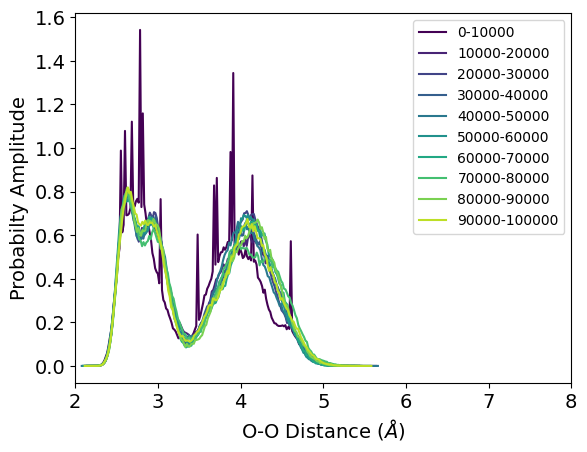

In [11]:
starts = np.arange(0,100000,10000)

# Choose a colormap (e.g., viridis, plasma, inferno, magma, cividis, etc.)
cmap = plt.cm.viridis

# Generate a list of colors from the colormap
colors = [cmap(i / len(starts)) for i in range(len(starts))]

for i in range(len(starts)):

    snapshots = np.arange(starts[i],starts[i]+5000,500)

    tutorial_sim = pv.SimInfo(f'C:/Users/gjaco/OneDrive/Documents/UW/McCoy Group/H11O6-/Data/NN_Data/3_2_start/450_3hidden_6_decay_0_dropout_2mill_revised_molec_atom_sort_standardized/model_5_reg/dist_65_energy_1/h2o_guided/1.0w_100000_walkers_100000t_1dt/H11O6_0_sim_info.hdf5')
    coords, weights = tutorial_sim.get_wfns(snapshots)
    coords = pv.Constants.convert(coords,'angstroms',to_AU=False) # Conversion of cds to angstroms

    analyzer = pv.AnalyzeWfn(coords)

    OOs = [[0,3],[0,6],[0,9],[0,12],[0,15],[3,6],[3,9],[3,12],[3,15],[6,9],[6,12],[6,15],[9,12],[9,15],[12,15]]

    oo_cumulative = []
    total_dws = []
    for pair in OOs:
        bond_length = analyzer.bond_length(pair[0],pair[1])
        oo_cumulative.append(bond_length)
        total_dws.append(weights)

    oo_total = np.concatenate(oo_cumulative)
    total_dws = np.concatenate(total_dws)

    n, bins = np.histogram(oo_total,weights=total_dws,bins=200,density=True)
    bin_centers = (bins[:-1] + bins[1:]) / 2

    oo_eq_c5_ave = [3.0384,2.7884,4.8622]

    #oo_eq_3_2 = [4.137,3.031,3.716,4.610,2.682,3.474,3.872,2.780,2.596,3.910,2.783,3.905,2.821,2.557,3.686]
    oo_eq_4_1 = [3.266,5.322,3.212,4.528,2.758,3.385,3.951,2.963,2.637,3.844,3.124,2.877,2.923,2.679,3.708]

    #plt.vlines(oo_eq_c5_ave,0,0.2,color='tab:orange')
    #plt.vlines(oo_eq_4_1,0,0.2,color='magenta')
    plt.plot(bin_centers,n,color=colors[i],label=f'{starts[i]}-{starts[i]+10000}')

plt.legend(fontsize=10)
plt.xlim(2,8)
plt.xlabel(r'O-O Distance ($\AA$)')
#plt.ylim(0,1)
plt.ylabel('Probabilty Amplitude')
plt.show()

c:\Users\gjaco\OneDrive\Documents\UW\McCoy Group\Machine Learning\nn_dmc\src\nn_dmc\model_analysis.py:73: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\autograd\generated\python_variable_methods.cpp:836.)
  output_regular = torch.tensor([(10**(j))-100 for j in output])
c:\Users\gjaco\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\gjaco\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\_core\_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\gjaco\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\_core\_methods.py:222: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = 

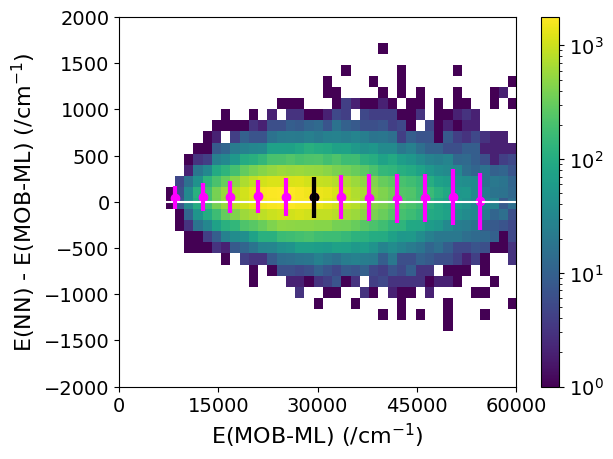

MAE: 171.16, average error: 50.14


In [5]:
plot_2d_pred_errors('h11o6',
                    './h11o6/models/h11o6_c5_and_4_1_5_reg_4mill_NN_model_450hidden_1e-6_decay_molec_atom_sorted_revised_standardized_0.pth',
                    './h11o6/training_sets/h11o6_mobml_10_test_molec_atom_sort_revised_X_4_1_new_5_reg_c5_and_4_1_4mill_standardized.npy',
                    './h11o6/training_sets/h11o6_mobml_10_test_y_4_1_new.npy')

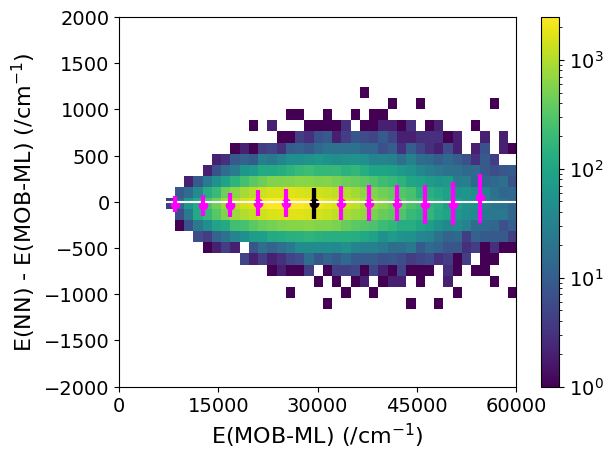

MAE: 126.77, average error: -17.60


In [6]:
plot_2d_pred_errors('h11o6',
                    './h11o6/models/h11o6_c5_and_4_1_5_reg_4mill_NN_model_450hidden_1e-6_decay_molec_atom_sorted_revised_standardized_0.pth',
                    './h11o6/training_sets/h11o6_mobml_10_test_molec_atom_sort_revised_X_c5_new_5_reg_c5_and_4_1_4mill_standardized.npy',
                    './h11o6/training_sets/h11o6_mobml_10_test_y_c5_new.npy')

c:\Users\gjaco\OneDrive\Documents\UW\McCoy Group\Machine Learning\nn_dmc\src\nn_dmc\model_analysis.py:73: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\autograd\generated\python_variable_methods.cpp:836.)
  output_regular = torch.tensor([(10**(j))-100 for j in output])
c:\Users\gjaco\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\gjaco\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\_core\_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\gjaco\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\_core\_methods.py:222: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = 

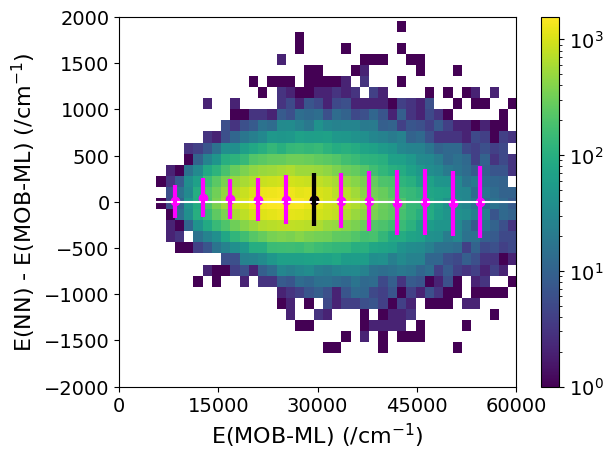

MAE: 209.46, average error: 16.32


In [99]:
plot_2d_pred_errors('h11o6',
                    './h11o6/models/h11o6_3_2_5_reg_no_B_NN_model_450hidden_1e-6_decay_molec_atom_sorted_revised_standardized_0.pth',
                    './h11o6/training_sets/h11o6_mobml_10_test_molec_atom_sort_revised_X_3_2_new_5_reg_no_B_standardized.npy',
                    './h11o6/training_sets/h11o6_mobml_10_test_y_3_2_new.npy')

In [88]:
input_size = 136
hidden_size = 450
output_size = 1

model = nn.Sequential(nn.Linear(input_size, hidden_size, bias=True),
                    nn.BatchNorm1d(hidden_size),
                    nn.SiLU(),
                    nn.Dropout(),
                    nn.Linear(hidden_size, hidden_size, bias=True),
                    nn.BatchNorm1d(hidden_size),
                    nn.SiLU(),
                    nn.Dropout(),
                    nn.Linear(hidden_size, hidden_size, bias=True),
                    nn.BatchNorm1d(hidden_size),
                    nn.SiLU(),
                    nn.Dropout(),
                    nn.Linear(hidden_size, output_size,bias=True),
                    nn.ReLU()

)

#load the model's state dictionary from the saved file
model.load_state_dict(torch.load('./h11o6/models/h11o6_c5_5_reg_NN_model_450hidden_1e-6_decay_molec_atom_sorted_revised_standardized_0.pth',map_location=torch.device('cpu')))

# Put the model in evaluation mode (important if you're doing inference)
#model.to(DEVICE)
model.eval()

means = np.load('./h11o6/training_sets/h11o6_mobml_full_training_molec_atom_sort_revised_X_c5_5_reg_means.npy')

stds = np.load('./h11o6/training_sets/h11o6_mobml_full_training_molec_atom_sort_revised_X_c5_5_reg_stds.npy')

def unsorted_CM(original_coords, atomic_numbers):
    """
    Calculate the Coulomb matrices for a batch of molecules with the same atomic numbers.
    
    Parameters:
    molecule_coords (np.ndarray): An array of shape (n_molecules, n_atoms, 3) containing the Cartesian coordinates.
    atomic_numbers (np.ndarray): An array of shape (n_atoms,) containing the atomic numbers.

    Returns:
    np.ndarray: An array of lower triangles of the group-sorted coulomb matrices of shape (n_molecules, n_atoms, n_atoms).
    """
    molecule_coords = original_coords
    
    n_molecules, n_atoms, _ = molecule_coords.shape
    
    # Initialize the Coulomb matrices
    coulomb_matrices = np.zeros((n_molecules, n_atoms, n_atoms))
    
    # Compute pairwise distance matrices
    distance_matrices = np.linalg.norm(molecule_coords[:, :, np.newaxis] - molecule_coords[:, np.newaxis, :], axis=-1)

    # Calculate off-diagonal elements
    #Z_product = atomic_numbers[:, np.newaxis] * atomic_numbers[np.newaxis, :]
    with np.errstate(divide='ignore', invalid='ignore'):
        coulomb_matrices = 1 / distance_matrices
        coulomb_matrices[distance_matrices == 0] = 0  # Handle division by zero
    
    # Identify molecules with any close atom pairs
    mask = np.any(coulomb_matrices > 0.8, axis=(1, 2))
    bad_geoms = np.where(mask)[0].tolist()

    # Calculate diagonal elements
    diagonal_elements = atomic_numbers
    np.einsum('ijj->ij', coulomb_matrices)[:] = diagonal_elements
    
    lower_triangles = np.zeros((n_molecules, n_atoms * (n_atoms - 1) // 2))
    
    for a in range(n_molecules):

        lower_triangles[a] = coulomb_matrices[a][np.tril_indices(n_atoms, -1)]
    
    return lower_triangles, bad_geoms

def molec_atom_sorted_CM(original_coords, atomic_numbers):
    """
    Calculate the Coulomb matrices for a batch of molecules with the same atomic numbers.
    
    Parameters:
    molecule_coords (np.ndarray): An array of shape (n_molecules, n_atoms, 3) containing the Cartesian coordinates.
    atomic_numbers (np.ndarray): An array of shape (n_atoms,) containing the atomic numbers.

    Returns:
    np.ndarray: An array of lower triangles of the group-sorted coulomb matrices of shape (n_molecules, n_atoms, n_atoms).
    """
    molecule_coords = original_coords
    
    n_molecules, n_atoms, _ = molecule_coords.shape
    
    # Initialize the Coulomb matrices
    coulomb_matrices = np.zeros((n_molecules, n_atoms, n_atoms))
    
    # Compute pairwise distance matrices
    distance_matrices = np.linalg.norm(molecule_coords[:, :, np.newaxis] - molecule_coords[:, np.newaxis, :], axis=-1)
    
    # Calculate off-diagonal elements
    #Z_product = atomic_numbers[:, np.newaxis] * atomic_numbers[np.newaxis, :]
    with np.errstate(divide='ignore', invalid='ignore'):
        coulomb_matrices = 1 / distance_matrices
        coulomb_matrices[distance_matrices == 0] = 0  # Handle division by zero
    
    # Identify molecules with any close atom pairs
    mask = np.any(coulomb_matrices > 0.814, axis=(1, 2))
    bad_geoms = np.where(mask)[0].tolist()

    # Calculate diagonal elements
    diagonal_elements = atomic_numbers
    np.einsum('ijj->ij', coulomb_matrices)[:] = diagonal_elements
    
    groups = [[0,1,2], [3,4,5], [6,7,8], [9,10,11], [12,13,14], [15,16]]
    group_sizes = [3, 3, 3, 3, 3, 2]
    group_starts = [0, 3, 6, 9, 12, 15]
    
    lower_triangles = np.zeros((n_molecules, n_atoms * (n_atoms - 1) // 2))
  
    for a in range(n_molecules):
        reorder = []
        group_norms = []
        for i in range(len(group_sizes)):
            start = group_starts[i]
            end = start+group_sizes[i]
            reorder.append(np.argsort([np.linalg.norm(coulomb_matrices[a][j]) for j in range(start,end)])+start)
            
            group_norm = np.sum([np.linalg.norm(coulomb_matrices[a][j]) for j in range(start,end)])
            group_norms.append(group_norm)

        group_order = np.argsort(group_norms)

        sorted_indices = []
        for i in range(len(group_sizes)):
            sorted_indices.append(reorder[group_order[i]])

        sorted_CM = coulomb_matrices[a][:, np.concatenate(sorted_indices)][np.concatenate(sorted_indices), :]

        lower_tri = np.tril_indices(17, -1)
        
        lower_triangles[a] = sorted_CM[lower_tri]
    
    return lower_triangles, bad_geoms

def cart_to_pot(cds):
    atoms = np.array([8, 1, 1, 8, 1, 1, 8, 1, 1, 8, 1, 1, 8, 1, 1, 8, 1])
        
    features, bad_geoms = molec_atom_sorted_CM(cds,atoms)

    std_features = (features-means)/stds

    energy = model(torch.tensor(std_features,dtype=torch.float32))
    energy_unshifted = torch.tensor([(10**(i)-100) for i in energy])

    energy_values = energy_unshifted.detach().numpy().reshape(len(cds))
    energy_values[bad_geoms] = 1
    
    return energy_values

In [89]:
ffnn_energies = cart_to_pot(h11o6_c5_snapshot_cds_part)

In [50]:
cart_to_pot(h11o6_3_2_book_opt.reshape(1,17,3))

array([1309.3032], dtype=float32)

In [95]:
from h11o6.models.egnn.h11o6_egnn_training_4_1_2 import EGNNModelLN

# Pre-load model globally

atom_types = torch.tensor([8.0, 1.0, 1.0, 8.0, 1.0, 1.0,
8.0, 1.0, 1.0, 8.0, 1.0, 1.0,
8.0, 1.0, 1.0, 8.0, 1.0], dtype=torch.float32)

model = EGNNModelLN(n_atoms=17, atom_types_list=atom_types, hidden_dim=64, num_layers=3, n_freqs=3, coord_rescale=0.01)
ckpt = torch.load("h11o6/models/egnn/h11o6_egnn_c5_64_3_3_ln_best.pth", map_location="cpu")
model.load_state_dict(ckpt["model_state"])
model.eval()
mu = ckpt["mu"]
sigma = ckpt["sigma"]

# Pre-allocate atom types tensor

_atom_types_tensor = atom_types.unsqueeze(0).unsqueeze(-1)  # (1,17,1)

def cart_to_pot_fast(coords_np, batch_size=1024):
  """
  Optimized CPU evaluation of geometries in batches.
  coords_np: np.ndarray of shape (N,17,3)
  Returns: np.ndarray of energies in a.u.
  """
  N_total = coords_np.shape[0]
  energies = np.empty((N_total,), dtype=np.float32)
  
  with torch.inference_mode():
      for start in range(0, N_total, batch_size):
          end = min(start + batch_size, N_total)
          batch = torch.tensor(coords_np[start:end], dtype=torch.float32)  # (B,17,3)
          B = batch.shape[0]
  
          # expand atom types once per batch
          z = _atom_types_tensor.expand(B, -1, -1)  # (B,17,1)
  
          y_norm = model(batch, z).squeeze(-1)  # (B,)
  
          # store energies in-place
          energies[start:end] = (y_norm * sigma + mu).numpy()
  
  return energies  # convert to a.u.



In [201]:
cds_test = np.load('./h11o6/training_sets/h11o6_mobml_10_test_cds_3_2_new.npy')
y_test = np.load('./h11o6/training_sets/h11o6_mobml_10_test_y_3_2_new.npy')
energies_test = 10**y_test - 100

In [96]:
cds_test = h11o6_c5_snapshot_cds_part
energies_test = h11o6_c5_snapshot_energies

In [97]:
output = cart_to_pot_fast(cds_test)

In [56]:
output.shape

(41000,)

In [57]:
energies_test.shape

(41000,)

In [98]:
test_errors = output - energies_test

average_error = np.mean(test_errors)

In [99]:
test_MAE = np.mean(np.abs(test_errors))

In [100]:
test_MAE

np.float64(630.104019768029)

c:\Users\gjaco\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\gjaco\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\_core\_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\gjaco\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\_core\_methods.py:222: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\gjaco\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\_core\_methods.py:180: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\gjaco\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\_core\_methods.py:214: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret 

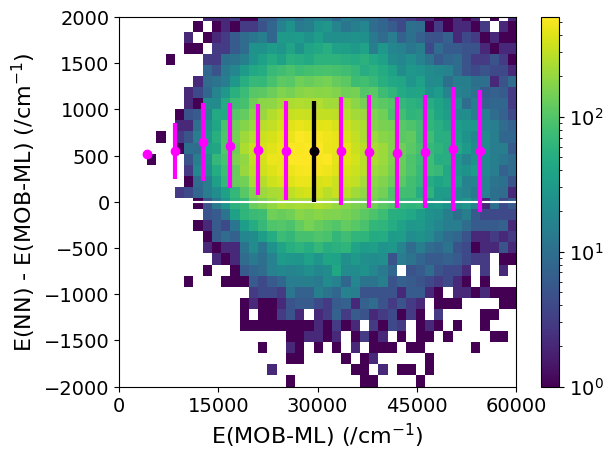

MAE: 630.10, average error: 551.56


In [101]:
bin_width = 1400
bin_height = 120
xlim = 60000
ylim = 2000
x_ticks = np.arange(0,75000,15000)

fig, ax = plt.subplots()

h = ax.hist2d(energies_test,test_errors,bins=[np.arange(0,xlim+bin_width,bin_width),np.arange(-ylim,ylim+bin_height,bin_height)],norm=LogNorm(vmin=1),cmap = 'viridis')

fig.colorbar(h[3], ax=ax)

plt.hlines(0,0,xlim,color = 'white',linewidth = 1.5)

steps = np.arange(0,41,3)

error_pairs = []
for i in range(len(test_errors)):
    error_pairs.append([energies_test[i],test_errors[i]])
    
bins = []
for i in range(len(h[1])-1):
    bin_elements = []
    for pair in error_pairs:
        if h[1][i] < pair[0] and h[1][i+1] > pair[0]:
            bin_elements.append(pair[1])
    bins.append(bin_elements)
    
bin_stats = []
for k in bins:
    bin_stats.append([np.mean(k),np.std(k)])

for j in steps:
    #mid_bin = (h[1][steps[j]]+h[1][steps[j+1]])/2
    plt.vlines(h[1][j],bin_stats[j][0]-bin_stats[j][1],bin_stats[j][0]+bin_stats[j][1],color = 'magenta',linewidth = 3)
    plt.scatter(h[1][j],bin_stats[j][0],color = 'magenta')

j = steps[7]
plt.vlines(h[1][j],bin_stats[j][0]-bin_stats[j][1],bin_stats[j][0]+bin_stats[j][1],color = 'black',linewidth = 3)
plt.scatter(h[1][j],bin_stats[j][0],color = 'black')
    
plt.xlim(0,xlim)
plt.xlabel('E(MOB-ML) (/cm$^{-1}$)',fontsize=16)
plt.ylabel(r'E(NN) - E(MOB-ML) (/cm$^{-1}$)',fontsize=16)
plt.ylim(-ylim,ylim)

plt.xticks(x_ticks)

plt.show()

print('MAE: {0:0.2f}, average error: {1:0.2f}'.format(test_MAE,average_error))


In [19]:
#book optimization
-457.85459788929717*au_to_cm - energy_shift

1295.1704331040382

In [21]:
h11o6_3_2_book_opt = np.array([-4.55703434, -0.30208288,  2.392099,   -3.39470993, -0.4298726,  0.82983697,
 -6.02608311, -1.30481959,  2.09764544,  2.15873081,  2.40807322,  1.44097777,
  0.83706098, 1.51695575,  0.48393076,  1.49975248, 2.50110669,  3.12864478,
 -1.27309151,  1.87728403,  5.86549257, -2.52070078,  1.25575116,  4.67079459,
 -0.50880591,  0.36533379,  6.50821378,  1.59616535, -4.1645709,  -2.04302658,
  0.88807164, -5.63445899, -1.27133533,  0.34343392, -2.75093229, -1.69462384,
  5.92144129, -1.48402031,  0.11250125,  4.65018657, -2.58902108, -0.59848354,
  4.99718638,  0.06330862,  0.41727383, -1.36104569, -0.40938528, -1.13109855,
 -1.89612977,  0.21321998, -2.7424962 ]).reshape(17,3)

In [22]:
save_xyz_file('./h11o6/geometries/h11o6_3_2_book_mobml_min.xyz',h11o6_atom_names,h11o6_3_2_book_opt*au_to_ang)

In [108]:
#new c5
-457.8510452237062*au_to_cm - energy_shift

2074.8904040306807

In [109]:
h11o6_3_2_up_down_current = np.array([-5.19012673,  2.48490874,  0.50049639, -4.16140358,  1.98024484, -0.94523101,
 -4.45108731,  1.57917835,  1.8824176,   0.4541031,   1.00087936,  2.58037763,
  0.02805151,  2.26507734,  1.34829982,  0.13499535, -0.57512938,  1.659691,
  3.29150457,  2.34962092, -3.21073588,  3.64891112,  1.70686639, -1.54980549,
  1.47643108,  1.99827471, -3.39986166, -0.11060966, -2.69757701, -0.84596281,
 -1.54241179, -3.81113789, -0.87347237, -0.82580123, -0.97768312, -1.91210566,
  3.15469913, -2.88953634, -5.10168342,  2.09084789, -3.07753297, -3.62635267,
  3.48686847, -1.10703686, -5.09747675, -1.69900569,  0.91067681, -3.17923094,
 -2.18977871, -0.01829788, -4.6611643 ]).reshape(17,3)

In [110]:
save_xyz_file('./h11o6/geometries/h11o6_3_2_up_down_current.xyz',h11o6_atom_names,h11o6_3_2_up_down_current*au_to_ang)

In [53]:
file = 'C:/Users/gjaco/OneDrive/Documents/UW/McCoy Group/H11O6-/Data/EGNN_Data/c5_start/64_3layers_3freqs_6decay_1gradclip_2mill_std_energies/gpu/h2o_guided/1.0w_100000_walkers_100000t_1dt/wfns/H11O6_1_wfn_79000ts.hdf5'

In [18]:
f = h5py.File(file, "r")
for key in f.keys():
       print(key)

coords
desc_wts


In [21]:
cds = f['coords']
weights = f['desc_wts']

In [2]:
max_cds = get_max_wt_wfn('C:/Users/gjaco/OneDrive/Documents/UW/McCoy Group/H11O6-/Data/EGNN_Data/3_2_up_down_start/64_3layers_3freqs_6decay_1gradclip_2mill_std_energies/gpu/h2o_guided/1.0w_100000_walkers_100000t_1dt/wfns/H11O6_0_wfn_25000ts.hdf5')

In [4]:
save_xyz_file(f'{path}/h11o6/geometries/h11o6_3_2_up_down_guided_0_max_25kts.xyz',h11o6_atom_names,max_cds*au_to_ang)

In [42]:
max_cds

array([[-5.30163348e+00,  1.33958895e+00,  1.34995682e+00],
       [-4.68621721e+00,  1.26257949e+00, -2.64664997e-01],
       [-3.88050423e+00,  1.02711711e+00,  2.56017638e+00],
       [ 5.28136229e-01,  1.73492067e+00,  2.51601440e+00],
       [-2.91355802e-01,  2.05664705e+00,  8.44893924e-01],
       [ 7.01397323e-01,  1.17642243e-01,  2.03112749e+00],
       [ 3.23383738e+00,  2.15123850e+00, -3.29431511e+00],
       [ 3.48618499e+00,  2.32280176e+00, -1.62630467e+00],
       [ 1.29443237e+00,  2.00231039e+00, -3.02629470e+00],
       [-1.40493088e-01, -2.72352703e+00, -5.83036543e-01],
       [-1.48545410e+00, -3.93718595e+00, -7.87203725e-01],
       [-8.71943133e-01, -1.13169564e+00, -1.39311277e+00],
       [ 1.89323548e+00, -2.94505857e+00, -5.87445875e+00],
       [ 1.17016843e+00, -3.72026042e+00, -4.43485842e+00],
       [ 2.74929266e+00, -1.27568519e+00, -5.54204614e+00],
       [-1.94053174e+00,  9.16210497e-01, -2.93195318e+00],
       [-3.04609722e+00,  7.29321710e-05

In [44]:
cart_to_pot_fast(np.array([max_cds]))

array([10769.676], dtype=float32)

In [46]:
-457.79470595*au_to_cm - energy_shift

14439.931731969118

In [85]:
h11o6_c5_snapshot_cds = np.load('./h11o6/training_sets/h11o6_c5_unguided_100k_125kts_snapshot.npy')

In [186]:
h11o6_c5_snapshot_energies = []
for i in np.arange(0, len(h11o6_c5_snapshot_cds), 1000):
    try:
        energy = np.load(f'{path}/h11o6/training_sets/h11o6_snapshots/{i}-{i+1000}_c5_energies.npy')
        h11o6_c5_snapshot_energies.append(energy)
    except:
        print(f'Skipping {i}-{i+1000}')
        continue
h11o6_c5_snapshot_energies = np.concatenate(h11o6_c5_snapshot_energies)*au_to_cm - energy_shift

NameError: name 'h11o6_c5_snapshot_cds' is not defined

In [50]:
len(h11o6_3_2_snapshot_energies)

41000

In [87]:
first = h11o6_c5_snapshot_cds[:60000]
second = h11o6_c5_snapshot_cds[65000:79000]
h11o6_c5_snapshot_cds_part = np.concatenate([first,second])

In [76]:
h11o6_4_1_snapshot_cds_part.shape

(79000, 17, 3)

In [64]:
read_xyz_file('./h11o6/geometries/c5_isom_current.xyz')

array([[-4.99431104,  2.85356531,  1.49841384],
       [-3.78806373,  2.30121231,  0.1999704 ],
       [-4.13566831,  4.31098639,  2.14685086],
       [-0.25095006,  6.40975405,  0.3538017 ],
       [-0.494261  ,  4.76417524, -0.49091439],
       [ 1.53820153,  6.52965118,  0.53783766],
       [ 3.84723927,  2.25039946, -1.43581273],
       [ 4.43653887,  0.75193413, -0.60775798],
       [ 1.99715772,  2.00476222, -1.61003495],
       [-1.13982384, -2.96231938, -1.02941067],
       [-2.84682627, -3.49511431, -0.7852611 ],
       [-1.22542991, -1.0830078 , -1.35947127],
       [ 3.21907884, -4.20000279, -3.62898326],
       [ 1.62257543, -4.02975695, -2.72935147],
       [ 3.48620193, -2.54197808, -4.30008117],
       [-1.17129061,  1.82108788, -1.85099183],
       [-1.68117426,  2.10723635, -3.56327478]])